# The UCI User Knowledge Modeling

### Import libraries

In [11]:
from ucimlrepo import fetch_ucirepo
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns

### Preparing the datasets

In [12]:
wine_quality = fetch_ucirepo(id=257)
X = wine_quality.data.features 
y = wine_quality.data.targets 

y = y['UNS'].map({
    'very_low': '0',
    'Very Low': '0',
    'Low': '1',
    'Middle': '2',
    'High': '3'
})

test_sizes = [.6, .4, .2, .1]
datasets = {}
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=22125, stratify=y)
    datasets[test_size] = {
        "feature_train": X_train,
        "feature_test": X_test,
        "label_train": y_train,
        "label_test": y_test
    }

https://archive.ics.uci.edu/static/public/257/data.csv


### Visualizing the data

#### Histogram plot function

In [13]:
from matplotlib.axes import Axes

def plot_distribution(ax: Axes, data, title):
    unique, counts = np.unique(data, return_counts=True)
    total_count = sum(counts)
    frequencies = counts / total_count

    bars = ax.bar(unique, counts, edgecolor='black', label='Count')
    ax.set_ylabel('Count')
    ax.tick_params(axis='y')
    ax.set_xticks(unique)
    ax.set_xticklabels(['Very Low', 'Low', 'Middle', 'High'])

    for bar, count, freq in zip(bars, counts, frequencies):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_count / 569 * 5,
                f'{count} ({freq*100:.2f}%)', ha='center', color='darkgreen', fontsize=10)

    ax2 = ax.twinx()
    ax2.plot(unique, frequencies, color='red', marker=' ', linestyle=' ', label='Frequency')
    ax2.set_ylabel('Frequency')
    ax2.tick_params(axis='y')
    ax2.grid(visible=True, linestyle='--', linewidth=0.5)

    ax.set_title(title)

#### Visualizing the distribution of the target variable in each subset

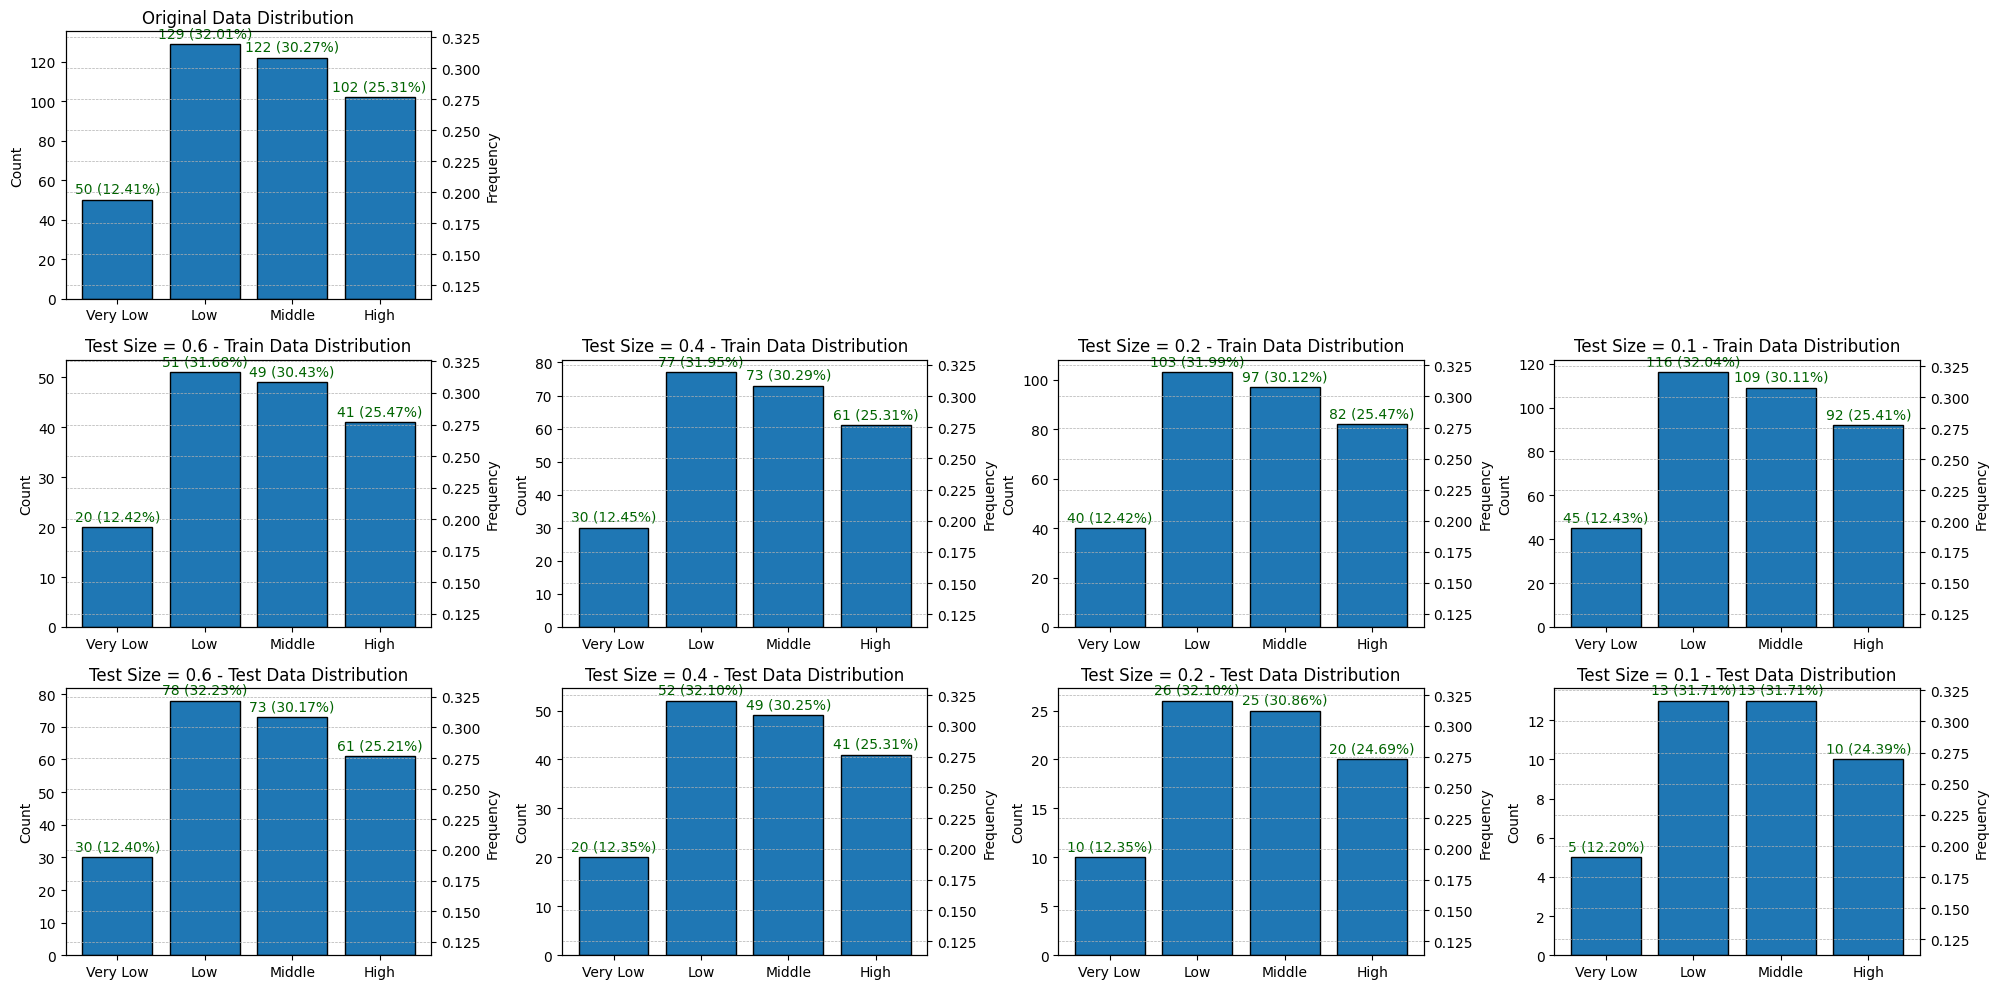

In [14]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 4, figure=fig)

# Original data distribution
ax = fig.add_subplot(gs[0, 0])
plot_distribution(ax, y, 'Original Data Distribution')

# Data distribution for each test size
for i, (test_size, data) in enumerate(datasets.items(), 0):
    ax = fig.add_subplot(gs[1, i])
    plot_distribution(ax, data['label_train'], f'Test Size = {test_size} - Train Data Distribution')

    ax = fig.add_subplot(gs[2, i])
    plot_distribution(ax, data['label_test'], f'Test Size = {test_size} - Test Data Distribution')

plt.tight_layout()
plt.savefig('../latex/figures/user_knowledge_modeling_split.pdf', format='pdf')

### Building the decision tree classifiers

#### Build trees

In [15]:
decision_trees = {
    test_size: 
        DecisionTreeClassifier(random_state=22125, criterion='entropy')
        .fit(data["feature_train"], data["label_train"])
    for test_size, data in datasets.items()
}

#### Tree visualizations

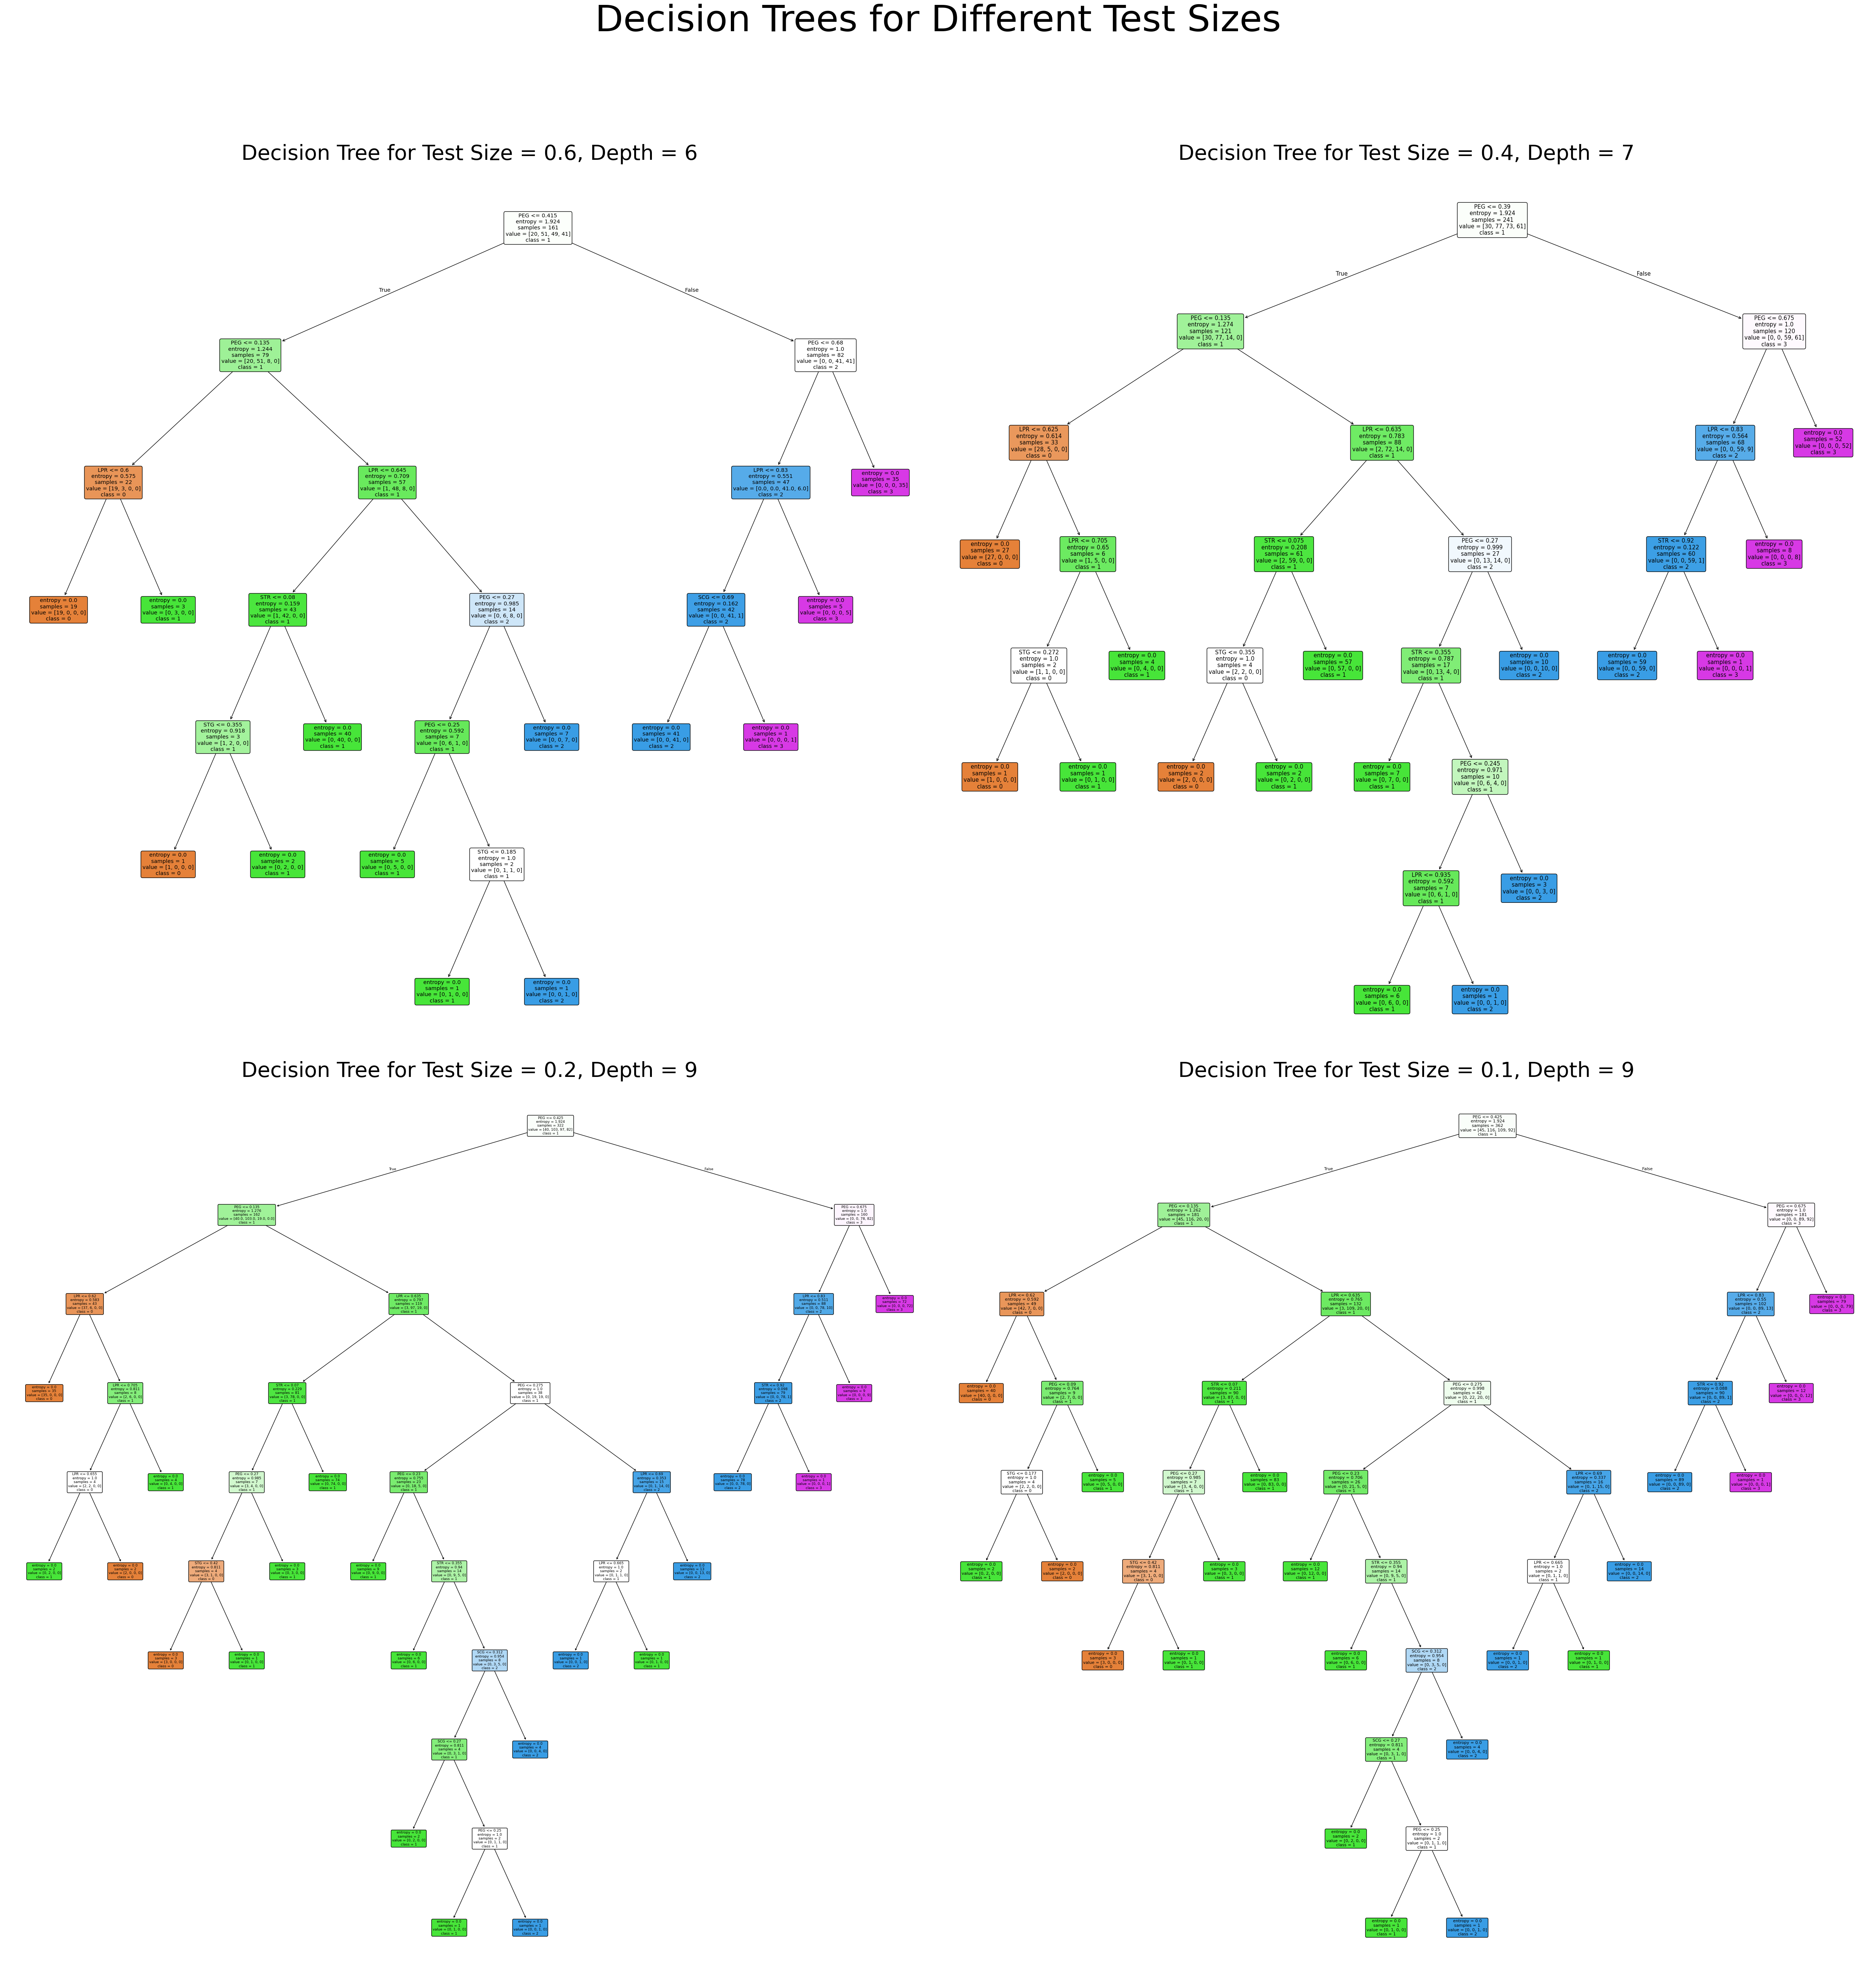

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(50, 50))

for ax, (test_size, tree) in zip(axs.ravel(), decision_trees.items()):
    plot_tree(tree, 
              feature_names=X.columns, 
              class_names=tree.classes_, 
              filled=True, 
              rounded=True, 
              ax=ax)
    ax.set_title(f'Decision Tree for Test Size = {test_size}, Depth = {tree.get_depth()}', fontsize=40)
fig.suptitle('Decision Trees for Different Test Sizes', fontsize=70, y=1.05)
plt.tight_layout()
plt.savefig('../latex/figures/user_knowledge_modeling_decision_trees.pdf', format='pdf')

### Evaluating the decision tree classifiers

#### Prepare the results

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

classification_reports = {}
classification_report_dicts = {}
confusion_matrices = {}
for test_size, data in datasets.items():
    y_true = data['label_test']
    y_pred = decision_trees[test_size].predict(data['feature_test'])
    
    classification_reports[test_size] = classification_report(y_true, y_pred)
    classification_report_dicts[test_size] = classification_report(y_true, y_pred, output_dict=True)
    confusion_matrices[test_size] = confusion_matrix(y_true, y_pred)

#### Classification report

In [18]:
for test_size, classification_report_str in classification_reports.items():
    print(f'Classification Report for Test Size = {test_size}')
    print(classification_report_str)

Classification Report for Test Size = 0.6
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.87      0.88      0.88        78
           2       0.88      0.84      0.86        73
           3       0.88      0.97      0.92        61

    accuracy                           0.88       242
   macro avg       0.88      0.87      0.88       242
weighted avg       0.88      0.88      0.88       242

Classification Report for Test Size = 0.4
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.88      0.88      0.88        52
           2       0.94      0.92      0.93        49
           3       0.95      1.00      0.98        41

    accuracy                           0.91       162
   macro avg       0.90      0.90      0.90       162
weighted avg       0.91      0.91      0.91       162

Classification Report for Test Size = 0.2
    

#### Confusion matrixes

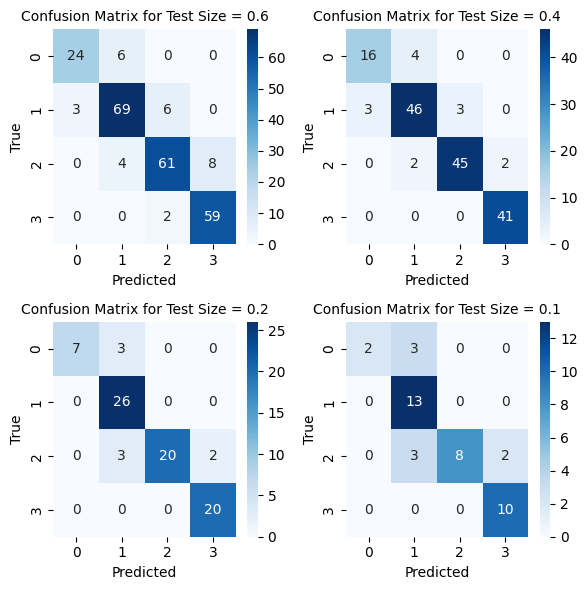

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ax, (test_size, confusion_matrix_data) in zip(axs.ravel(), confusion_matrices.items()):
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Test Size = {test_size}', fontsize=10)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    
plt.tight_layout()
plt.savefig('../latex/figures/user_knowledge_modeling_confusion_matrices.pdf', format='pdf')

### The depth and accuracy of a decision tree

#### Prepare trees

In [20]:
tree = decision_trees[0.2]
dataset = datasets[0.2]
max_depth = tree.get_depth()
tree_depths = {}

tree_depths[f'None\n({max_depth})'] = tree

for i in range(2, max(max_depth + 1, 8)):
    tree = DecisionTreeClassifier(random_state=22125, criterion='entropy', max_depth=i)
    tree.fit(dataset['feature_train'], dataset['label_train'])
    tree_depths[i] = tree

#### Plot tree with different depths

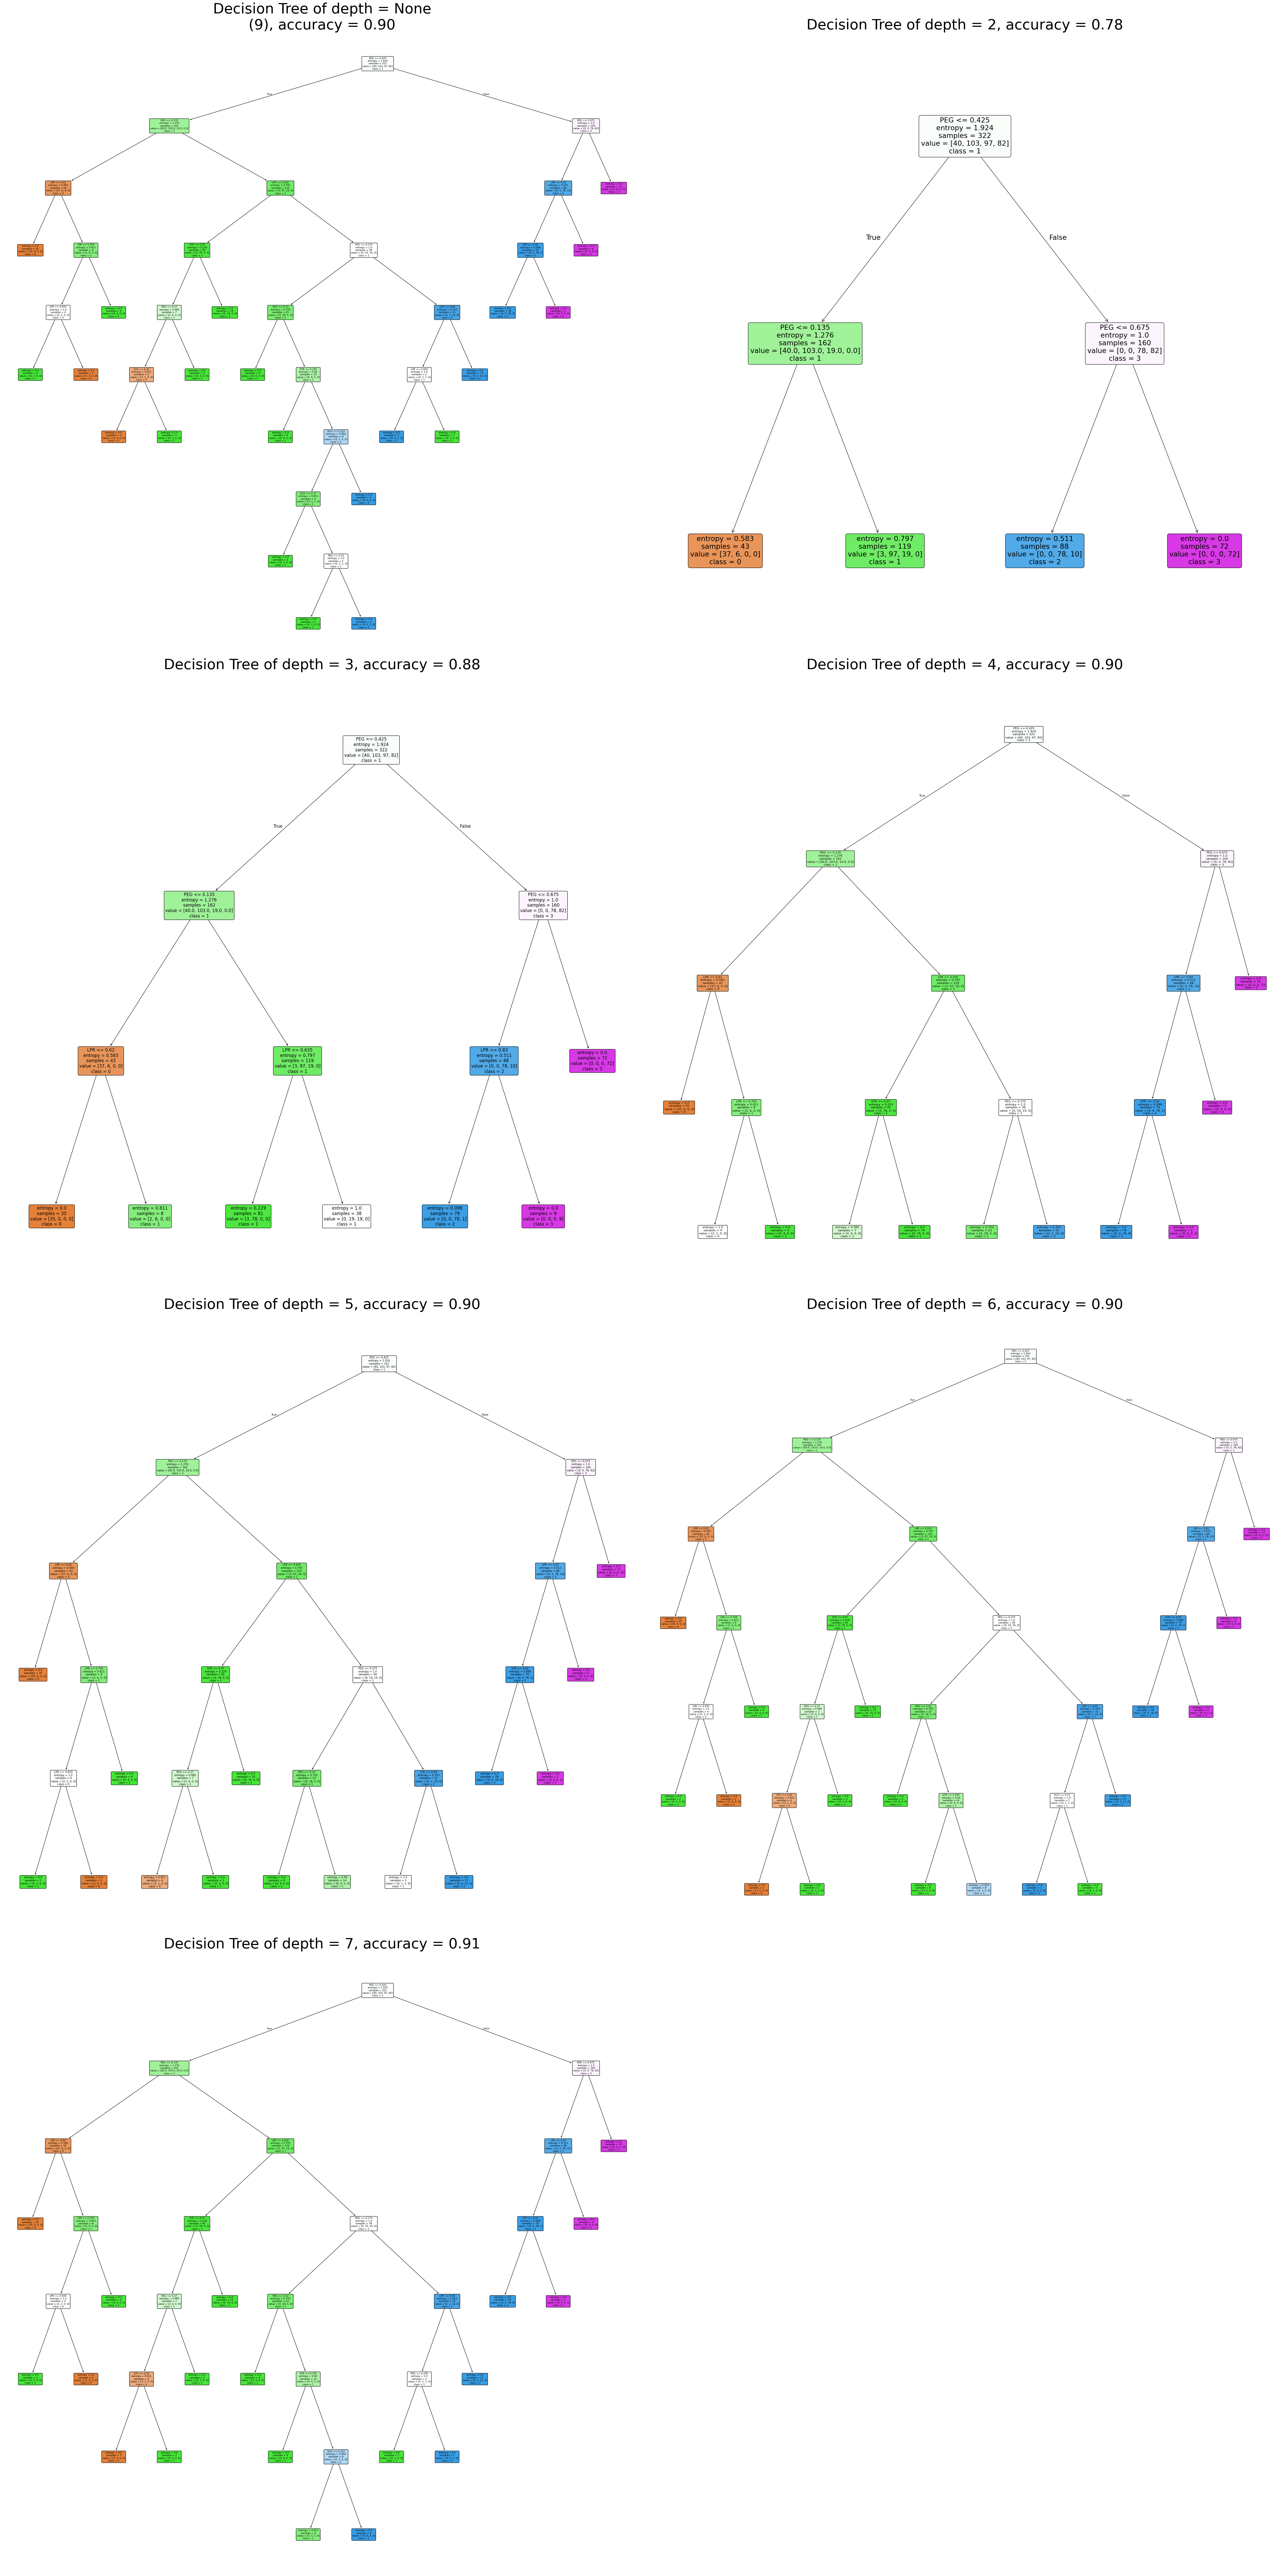

In [21]:
fig, axs = plt.subplots(4, 2, figsize=(50, 100))

for ax, (depth, tree), _ in zip(axs.ravel(), tree_depths.items(), range(7)):
    plot_tree(tree, 
              feature_names=X.columns, 
              class_names=tree.classes_, 
              filled=True, 
              rounded=True,
              ax=ax)
    ax.set_title(f'Decision Tree of depth = {depth}, accuracy = {tree.score(dataset["feature_test"], dataset["label_test"]):.2f}', fontsize=40)
axs[-1, -1].axis('off')

plt.tight_layout()

#### Plot accuracy with different depths

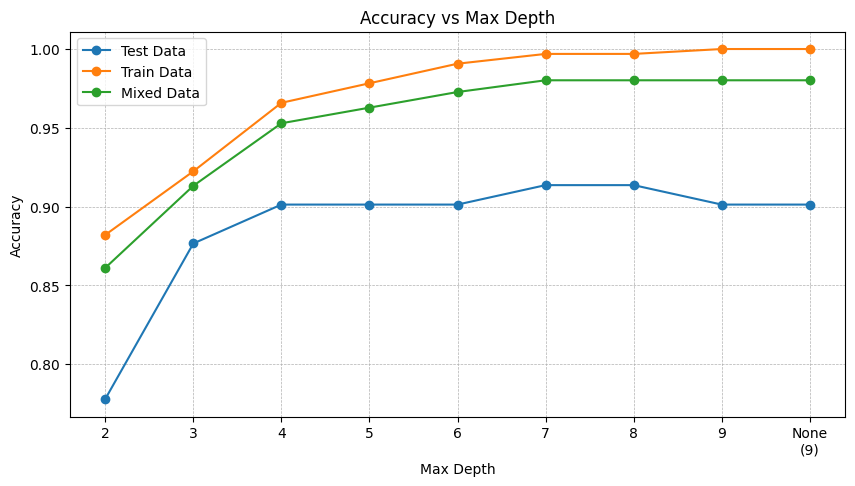

In [31]:
def get_accuracy(data_feature, data_label):
    acc = [(depth, tree.score(data_feature, data_label)) for depth, tree in tree_depths.items()]
    return acc[1:] + acc[:1]

test_data = get_accuracy(dataset['feature_test'], dataset['label_test'])
train_data = get_accuracy(dataset['feature_train'], dataset['label_train'])
mixed_data = get_accuracy(X, y)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(*zip(*test_data), label='Test Data', marker='o')
ax.plot(*zip(*train_data), label='Train Data', marker='o')
ax.plot(*zip(*mixed_data), label='Mixed Data', marker='o')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Max Depth')
ax.legend()
ax.grid(visible=True, linestyle='--', linewidth=0.5)
plt.savefig('../latex/figures/user_knowledge_modeling_accuracy_vs_max_depth.pdf', format='pdf')

### Latex helper functions

In [25]:
def latex_parse_classification_report(classification_report_dict):
    class_name_mapping = {
        '0': 'Very Low',
        '1': 'Low',
        '2': 'Middle',
        '3': 'High'
    }
    print(r"""\begin{tabular}{lcccccc}
\hline
 & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{Support} \\
\hline""")
    for class_name, class_report in classification_report_dict.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        print(f'{class_name_mapping[class_name]} & {class_report["precision"]:.2f} & {class_report["recall"]:.2f} & {class_report["f1-score"]:.2f} & {class_report["support"]:.0f} \\\\')
    print(
r"""\hline
\textbf{Accuracy} & & & <f1-acc> & <support-acc> \\
\textbf{Macro avg} & <f1-macro-avg> & <recall-macro-avg> & <precision-macro-avg> & <support-macro-avg> \\
\textbf{Weighted avg} & <f1-weighted-avg> & <recall-weighted-avg> & <precision-weighted-avg> & <support-weighted-avg> \\
\hline
\end{tabular}"""\
    .replace('<f1-acc>', f'{classification_report_dict["accuracy"]:.2f}')\
    .replace('<support-acc>', f'{classification_report_dict["macro avg"]["support"]:.0f}')\
    .replace('<f1-macro-avg>', f'{classification_report_dict["macro avg"]["f1-score"]:.2f}')\
    .replace('<recall-macro-avg>', f'{classification_report_dict["macro avg"]["recall"]:.2f}')\
    .replace('<precision-macro-avg>', f'{classification_report_dict["macro avg"]["precision"]:.2f}')\
    .replace('<support-macro-avg>', f'{classification_report_dict["macro avg"]["support"]:.0f}')\
    .replace('<f1-weighted-avg>', f'{classification_report_dict["weighted avg"]["f1-score"]:.2f}')\
    .replace('<recall-weighted-avg>', f'{classification_report_dict["weighted avg"]["recall"]:.2f}')\
    .replace('<precision-weighted-avg>', f'{classification_report_dict["weighted avg"]["precision"]:.2f}')\
    .replace('<support-weighted-avg>', f'{classification_report_dict["weighted avg"]["support"]:.0f}')
)

In [27]:
# latex_parse_classification_report(classification_report_dicts[0.6])
first = True
for test_size, classification_report_dict in classification_report_dicts.items():
    if first: first = False
    else: print(r'''
\vspace{2em}
''')
    print(r'\textbf{Classification Report for Test Size = <test-size>}'.replace('<test-size>', str(test_size)))
    print()
    latex_parse_classification_report(classification_report_dict)

\textbf{Classification Report for Test Size = 0.6}

\begin{tabular}{lcccccc}
\hline
 & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{Support} \\
\hline
Very Low & 0.89 & 0.80 & 0.84 & 30 \\
Low & 0.87 & 0.88 & 0.88 & 78 \\
Middle & 0.88 & 0.84 & 0.86 & 73 \\
High & 0.88 & 0.97 & 0.92 & 61 \\
\hline
\textbf{Accuracy} & & & 0.88 & 242 \\
\textbf{Macro avg} & 0.88 & 0.87 & 0.88 & 242 \\
\textbf{Weighted avg} & 0.88 & 0.88 & 0.88 & 242 \\
\hline
\end{tabular}

\vspace{2em}

\textbf{Classification Report for Test Size = 0.4}

\begin{tabular}{lcccccc}
\hline
 & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{Support} \\
\hline
Very Low & 0.84 & 0.80 & 0.82 & 20 \\
Low & 0.88 & 0.88 & 0.88 & 52 \\
Middle & 0.94 & 0.92 & 0.93 & 49 \\
High & 0.95 & 1.00 & 0.98 & 41 \\
\hline
\textbf{Accuracy} & & & 0.91 & 162 \\
\textbf{Macro avg} & 0.90 & 0.90 & 0.90 & 162 \\
\textbf{Weighted avg} & 0.91 & 0.91 & 0.91 & 162 \\
\hline
\end{tabular}

\vspace{2em}

\textbf{

In [28]:
for test_size, confusion_matrix_data in confusion_matrices.items():
    print(f"Confusion Matrix for Test Size = {test_size}:\n{confusion_matrix_data}")

Confusion Matrix for Test Size = 0.6:
[[24  6  0  0]
 [ 3 69  6  0]
 [ 0  4 61  8]
 [ 0  0  2 59]]
Confusion Matrix for Test Size = 0.4:
[[16  4  0  0]
 [ 3 46  3  0]
 [ 0  2 45  2]
 [ 0  0  0 41]]
Confusion Matrix for Test Size = 0.2:
[[ 7  3  0  0]
 [ 0 26  0  0]
 [ 0  3 20  2]
 [ 0  0  0 20]]
Confusion Matrix for Test Size = 0.1:
[[ 2  3  0  0]
 [ 0 13  0  0]
 [ 0  3  8  2]
 [ 0  0  0 10]]


In [29]:
# First feature of each decision tree
for test_size, tree in decision_trees.items():
    print(f"First feature of Decision Tree for Test Size = {test_size}: {X.columns[tree.tree_.feature[0]]}, entropy = {tree.tree_.impurity[0]:.5f}, samples = {tree.tree_.n_node_samples[0]}, threshold = {tree.tree_.threshold[0]:.2f}")

First feature of Decision Tree for Test Size = 0.6: PEG, entropy = 1.92401, samples = 161, threshold = 0.41
First feature of Decision Tree for Test Size = 0.4: PEG, entropy = 1.92375, samples = 241, threshold = 0.39
First feature of Decision Tree for Test Size = 0.2: PEG, entropy = 1.92378, samples = 322, threshold = 0.42
First feature of Decision Tree for Test Size = 0.1: PEG, entropy = 1.92372, samples = 362, threshold = 0.42


In [ ]:
# print all entropy values
for test_size, tree in decision_trees.items():
    print(f"Entropy values for Test Size = {test_size}: {tree.tree_.impurity}")

Entropy values for Test Size = 0.6: [0.93482571 0.61350685 0.71991529 0.89926547 0.81323013 0.52101694
 0.         0.68129089 0.         0.78172812 0.29747225 0.
 0.91829583 0.         0.         0.90902216 1.         0.89603823
 0.         0.99107606 0.         0.65002242 0.         0.
 0.         0.35335934 0.         0.         1.05157371 0.
 1.14872579 1.31724726 0.94637294 0.43949699 1.         0.
 0.         0.         0.91829583 0.         0.         1.2628839
 0.85240518 0.72192809 0.         0.         0.39124356 0.
 0.81127812 1.         0.         0.         0.         1.33826893
 0.76420451 0.         1.         0.         0.         0.91829583
 0.72192809 0.         0.         0.         0.7085967  0.53495472
 0.40963344 0.         1.14883485 0.         1.         0.
 0.         0.         0.         0.99947302 0.73828487 0.
 0.         0.         0.51070686 0.20260411 0.72192809 0.
 0.91829583 0.         0.         0.07949044 0.65002242 0.
 0.         0.         0.6407613